In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sql_functions import open_connection
from sql_queries import product_reviews

In [2]:
DATABASE_FILE = "olist.db"
connection = open_connection(DATABASE_FILE)

Connection is successful


In [3]:
# Ignore warning for future deprecated method like distplot()
warnings.filterwarnings("ignore")

### **Case 2: Analyzing the Product Review**

#### 2.1 Loading, Modify and Get Basic Info of the Query
##### 2.1.1. Loading Query into DataFrame

In [4]:
df_product_reviews = pd.read_sql(product_reviews, connection)
df_product_reviews.head()

,order_id,product_name,review_score
0,e17e4f88e31525f7deef66779844ddce,perfumaria,5.0
1,5236307716393b7114b53ee991f36956,artes,5.0
2,01f66e58769f84129811d43eefd187fb,esporte_lazer,5.0
3,143d00a4f2dde4e0364ee1821577adb3,bebes,1.0
4,86cafb8794cb99a9b1b77fc8e48fbbbb,utilidades_domesticas,5.0


In [5]:
print("Data Frame Shape: ", df_product_reviews.shape)
print("\nData Frame information")
df_product_reviews.info()

Data Frame Shape:  (113314, 3)

Data Frame information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113314 entries, 0 to 113313
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      113314 non-null  object 
 1   product_name  111702 non-null  object 
 2   review_score  112372 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.6+ MB


#### 2.2 Data Cleaning
##### 2.2.1. Finding and Replace Null

In [6]:
df_product_reviews.isnull().sum()

order_id           0
product_name    1612
review_score     942
dtype: int64

In [7]:
df_product_reviews["product_name"].fillna("Unknown", inplace=True)
df_product_reviews.isna().sum()

order_id          0
product_name      0
review_score    942
dtype: int64

In [8]:
df_review_table = pd.read_sql("SELECT review_id, review_score "
                              "FROM olist_order_reviews_dataset", connection)
df_review_table.isna().sum()

review_id       0
review_score    0
dtype: int64

In [9]:
df_order_table = pd.read_sql("SELECT order_id FROM olist_order_dataset", connection)
df_order_table.isna().sum()

order_id    0
dtype: int64

In [10]:
df_order_item_table = pd.read_sql("SELECT product_id, order_id "
                                  "FROM olist_order_items_dataset", connection)
df_order_item_table.isna().sum()

product_id    0
order_id      0
dtype: int64

In [11]:
cte_query = """
SELECT
	order_items.product_id,
	order_data.order_id,
	reviews.review_id,
	reviews.review_score,
	order_data.order_status
FROM olist_order_dataset AS order_data
LEFT JOIN olist_order_reviews_dataset AS reviews ON order_data.order_id = reviews.order_id
LEFT JOIN olist_order_items_dataset AS order_items ON order_data.order_id = order_items.order_id
"""
df_cte_table = pd.read_sql(cte_query, connection)
df_cte_table.isna().sum()

product_id      778
order_id          0
review_id       961
review_score    961
order_status      0
dtype: int64

In [12]:
df_product_reviews.dropna(subset=["review_score"], inplace=True)
df_product_reviews.isna().sum()

order_id        0
product_name    0
review_score    0
dtype: int64

#### 2.2.2 Finding Duplicates

In [13]:
df_product_reviews[df_product_reviews.duplicated(keep=False)]

,order_id,product_name,review_score
8,6ecf7023e8dd4ec8b08746c35b9fcb60,moveis_decoracao,2.0
9,6ecf7023e8dd4ec8b08746c35b9fcb60,moveis_decoracao,2.0
10,8ac5b235603eee2e21e36261b2df536c,moveis_decoracao,2.0
11,8ac5b235603eee2e21e36261b2df536c,moveis_decoracao,2.0
12,c5874d438cf199ea7c0f27967f6cf462,moveis_decoracao,1.0
...,...,...,...
113308,59e88b7d3675e89aceaf86f372d3bc9a,informatica_acessorios,4.0
113309,59e88b7d3675e89aceaf86f372d3bc9a,informatica_acessorios,4.0
113310,6e4465d771f02e4fe335225de3c6c043,informatica_acessorios,5.0
113311,6e4465d771f02e4fe335225de3c6c043,informatica_acessorios,5.0


In [14]:
df_product_reviews.drop_duplicates(keep="first", inplace=True)

#Re-Check duplicates
df_product_reviews[df_product_reviews.duplicated()]

,order_id,product_name,review_score


#### Formatting Data

In [15]:
from products_translation import products

df_product_reviews.replace(products, inplace=True)
df_product_reviews["product_name"].head()

0         Perfumery
1               Art
2    Sports leisure
3              Baby
4        Housewares
Name: product_name, dtype: object

In [16]:
df_product_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98924 entries, 0 to 113313
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      98924 non-null  object 
 1   product_name  98924 non-null  object 
 2   review_score  98924 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.0+ MB


In [17]:
df_product_reviews = df_product_reviews.astype({"review_score": "int64"})
df_product_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98924 entries, 0 to 113313
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_id      98924 non-null  object
 1   product_name  98924 non-null  object
 2   review_score  98924 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.0+ MB


#### Data Analysis
<p>Ordered Product Ranking Score</p>
<p>Proportion of product in the rank</p>

In [27]:
df_analysis2 = df_product_reviews.groupby("review_score").agg("count")
print("Data shape: ", df_analysis2.shape)
df_analysis2.head()

Data shape:  (5, 2)


,order_id,product_name
review_score,,
1,11117,11117
2,3168,3168
3,8200,8200
4,19159,19159
5,57280,57280


In [28]:
df_analysis2.reset_index(inplace=True)

In [29]:
df_analysis2

,review_score,order_id,product_name
0,1,11117,11117
1,2,3168,3168
2,3,8200,8200
3,4,19159,19159
4,5,57280,57280


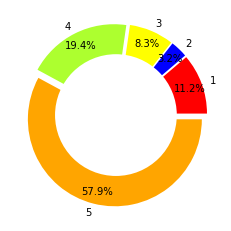

In [31]:
# Colors
colors = ['#FF0000', '#0000FF', '#FFFF00', 
          '#ADFF2F', '#FFA500']

explode = (0.05, 0.05, 0.05, 0.05, 0.05)


plt.pie(df_analysis2["product_name"],
        colors=colors, labels=df_analysis2["review_score"],
        autopct="%1.1f%%", pctdistance=0.85, explode=explode)

centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig = plt.gcf()

fig.gca().add_artist(centre_circle)

plt.show()